In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [57]:

def load_data(file_path):
    with open(file_path) as f:
        data = json.load(f)
        return pd.json_normalize(data)

route = "../lighthouse/results/"
files = {
    "react_desktop": route + "react_desktop/dashboard/results.json",
    "vue_desktop": route + "vue_desktop/dashboard/results.json",
    "react_mobile": route + "react_mobile/dashboard/results.json",
    "vue_mobile": route + "vue_mobile/dashboard/results.json"
}

dataframes = {name: load_data(path) for name, path in files.items()}

dataframes["react_desktop"].head()
dataframes["vue_desktop"].head()
#dataframes["react_mobile"].head()
#dataframes["vue_mobile"].head()


,performance,metrics.firstContentfulPaint,metrics.largestContentfulPaint,metrics.timeToInteractive,metrics.totalBlockingTime,metrics.cumulativeLayoutShift
0,0.98,0.8 s,1.1 s,0.8 s,0 ms,0
1,1.00,0.5 s,0.8 s,0.5 s,0 ms,0
2,0.99,0.6 s,0.8 s,0.6 s,0 ms,0
3,0.98,0.8 s,1.0 s,0.8 s,0 ms,0
4,0.88,1.4 s,1.7 s,1.4 s,0 ms,0


In [58]:
# Convert metrics to numeric
def convert_metrics(df):
    for metric in ["metrics.firstContentfulPaint", "metrics.largestContentfulPaint", "metrics.timeToInteractive"]:
        # Remove strings convert seconds to milliseconds
        df[metric] = df[metric].str.replace(r"[^\d.]", "", regex=True).astype(float) * 1000

    # Convert totalBlockingTime to numeric (its already in milliseconds)
    df["metrics.totalBlockingTime"] = df["metrics.totalBlockingTime"].str.replace(r"[^\d.]", "", regex=True).astype(float)

    # Convert cumulativeLayoutShift to numeric (unitless)
    df["metrics.cumulativeLayoutShift"] = df["metrics.cumulativeLayoutShift"].astype(float)

    return df

dataframes = {name: convert_metrics(df.copy()) for name, df in dataframes.items()}

In [59]:
dataframes["react_desktop"].head()

,performance,metrics.firstContentfulPaint,metrics.largestContentfulPaint,metrics.timeToInteractive,metrics.totalBlockingTime,metrics.cumulativeLayoutShift
0,0.99,600.0,800.0,600.0,0.0,0.0
1,0.99,600.0,900.0,600.0,0.0,0.0
2,0.99,600.0,900.0,700.0,0.0,0.0
3,0.99,600.0,800.0,700.0,0.0,0.0
4,0.99,600.0,800.0,600.0,0.0,0.0


In [60]:

# Normalize metrics, with min-max normalization
def normalize_metrics(df):
    metrics_to_normalize = ["metrics.firstContentfulPaint", "metrics.largestContentfulPaint",
                            "metrics.timeToInteractive", "metrics.totalBlockingTime", 
                            "metrics.cumulativeLayoutShift"]

    for metric in metrics_to_normalize:
        min_val = df[metric].min()
        max_val = df[metric].max()
        # Avoid division by zero 
        if max_val != min_val:
            df[metric] = (df[metric] - min_val) / (max_val - min_val)
        else:
            df[metric] = 0  

    return df

dataframes_normalized = {name: normalize_metrics(df.copy()) for name, df in dataframes.items()}


In [61]:
dataframes_normalized["react_desktop"].head()
#dataframes_normalized["vue_desktop"].head()

,performance,metrics.firstContentfulPaint,metrics.largestContentfulPaint,metrics.timeToInteractive,metrics.totalBlockingTime,metrics.cumulativeLayoutShift
0,0.99,0.125,0.000000,0.000000,0.0,0
1,0.99,0.125,0.142857,0.000000,0.0,0
2,0.99,0.125,0.142857,0.142857,0.0,0
3,0.99,0.125,0.000000,0.142857,0.0,0
4,0.99,0.125,0.000000,0.000000,0.0,0


In [62]:
# Detect outliers using the IQR method
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
    return outliers

outliers = {name: {col: detect_outliers(df, col) for col in df.columns if "metrics" in col} for name, df in dataframes_normalized.items()}

outliers["react_desktop"]["metrics.firstContentfulPaint"]
#outliers["react_desktop"]["metrics.largestContentfulPaint"]


,performance,metrics.firstContentfulPaint,metrics.largestContentfulPaint,metrics.timeToInteractive,metrics.totalBlockingTime,metrics.cumulativeLayoutShift
12,0.91,1.0,1.0,1.0,0.0,0


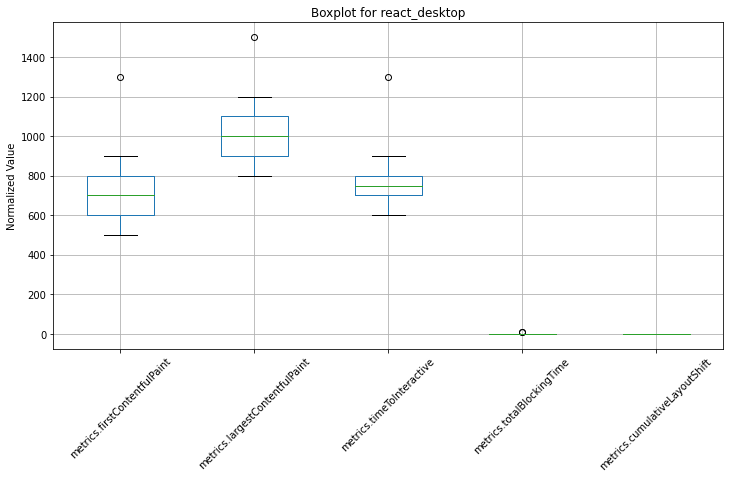

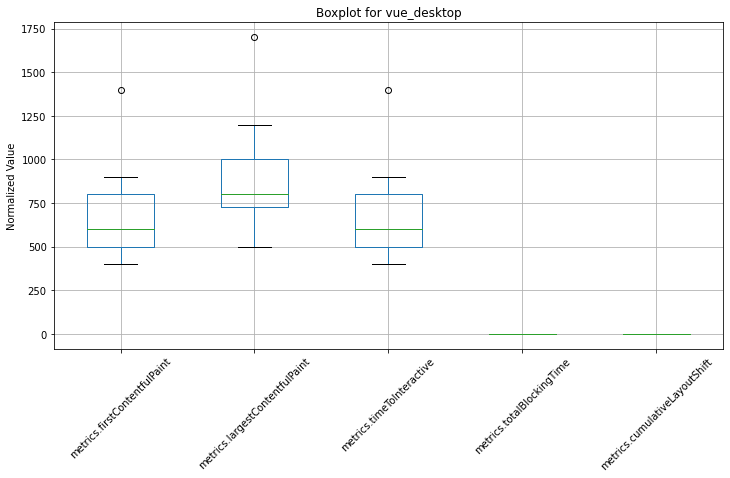

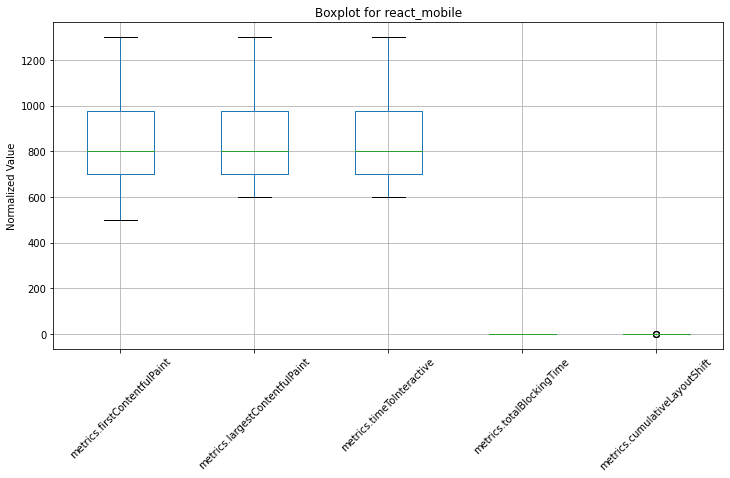

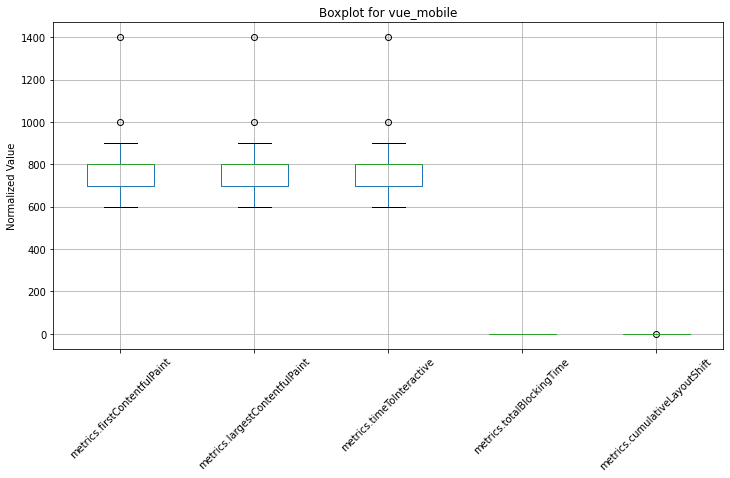

In [70]:

# Plotting boxplots for each dataset
for name, df in dataframes.items():
    plt.figure(figsize=(12, 6))
    df.boxplot(column=[col for col in df.columns if "metrics" in col])
    plt.title(f"Boxplot for {name}")
    plt.ylabel("Normalized Value")
    plt.xticks(rotation=45)
    plt.show()

In [64]:
from tabulate import tabulate

for dataset_name, metrics_outliers in outliers.items():
    print(f"\nOutliers for {dataset_name}:\n")
    for metric, outlier_df in metrics_outliers.items():
        if not outlier_df.empty:
            print(f"\n  Outliers in {metric}:\n")
            print(tabulate(outlier_df, headers='keys', tablefmt='grid'))
        else:
            print(f"\n  No outliers in {metric}.")



Outliers for react_desktop:


  Outliers in metrics.firstContentfulPaint:

+----+---------------+--------------------------------+----------------------------------+-----------------------------+-----------------------------+---------------------------------+
|    |   performance |   metrics.firstContentfulPaint |   metrics.largestContentfulPaint |   metrics.timeToInteractive |   metrics.totalBlockingTime |   metrics.cumulativeLayoutShift |
+====+===============+================================+==================================+=============================+=============================+=================================+
| 12 |          0.91 |                              1 |                                1 |                           1 |                           0 |                               0 |
+----+---------------+--------------------------------+----------------------------------+-----------------------------+-----------------------------+---------------------------------+

In [ ]:
from tabulate import tabulate

# Function to display outliers with the average for each metric
def display_outliers_with_average(outliers, dataframes):
    for dataset_name, metrics_outliers in outliers.items():
        print(f"\nOutliers for {dataset_name}:\n")
        df = dataframes_normalized[dataset_name]
        
        for metric, outlier_df in metrics_outliers.items():
            # Calculate the average (mean) for the metric in the full dataset
            average_with_outliers = df[metric].mean()

            # Filter out the outliers to calculate the average without them
            if not outlier_df.empty:
                non_outliers_df = df[~df.index.isin(outlier_df.index)]
                average_without_outliers = non_outliers_df[metric].mean()
                print(f"\n  Outliers in {metric} (Average with outliers: {average_with_outliers:.2f}, "
                      f"Average without outliers: {average_without_outliers:.2f}):\n")
                print(tabulate(outlier_df, headers='keys', tablefmt='grid'))
            else:
                print(f"\n  No outliers in {metric} (Average with outliers: {average_with_outliers:.2f}).")

display_outliers_with_average(outliers, dataframes)



Outliers for react_desktop:


  Outliers in metrics.firstContentfulPaint (Average with outliers: 0.30, Average without outliers: 0.28):

+----+---------------+--------------------------------+----------------------------------+-----------------------------+-----------------------------+---------------------------------+
|    |   performance |   metrics.firstContentfulPaint |   metrics.largestContentfulPaint |   metrics.timeToInteractive |   metrics.totalBlockingTime |   metrics.cumulativeLayoutShift |
+====+===============+================================+==================================+=============================+=============================+=================================+
| 12 |          0.91 |                              1 |                                1 |                           1 |                           0 |                               0 |
+----+---------------+--------------------------------+----------------------------------+-----------------------------+--

In [53]:
outlier_df

,iteration,performance,metrics.firstContentfulPaint,metrics.largestContentfulPaint,metrics.timeToInteractive,metrics.totalBlockingTime,metrics.cumulativeLayoutShift
1,1,1,0.25,0.25,0.25,0,0.0


In [66]:
# Function to remove outlier indices from the original dataframes based on the outliers dictionary
def remove_outliers_from_dataframes(outliers, dataframes):
    # Dictionary to store DataFrames without outliers
    dataframes_no_outliers = {}
    
    for dataset_name, metrics_outliers in outliers.items():
        df = dataframes[dataset_name].copy()  # Copy the original DataFrame
        
        # Collect unique indices of all outliers for this dataset
        outlier_indices = set()
        for metric, outlier_df in metrics_outliers.items():
            if not outlier_df.empty:
                # Collect indices of the outliers for the specific metric
                outlier_indices.update(outlier_df.index.tolist())
        
        # Drop rows with these outlier indices
        df_no_outliers = df.drop(outlier_indices)
        dataframes_no_outliers[dataset_name] = df_no_outliers

    return dataframes_no_outliers

# Apply the function to create DataFrames without outliers
dataframes_no_outliers = remove_outliers_from_dataframes(outliers, dataframes)

# Display a sample of the resulting DataFrames without outliers for verification
dataframes_no_outliers["vue_desktop"].head()  # Example output for react_desktop


,performance,metrics.firstContentfulPaint,metrics.largestContentfulPaint,metrics.timeToInteractive,metrics.totalBlockingTime,metrics.cumulativeLayoutShift
0,0.98,800.0,1100.0,800.0,0.0,0.0
1,1.00,500.0,800.0,500.0,0.0,0.0
2,0.99,600.0,800.0,600.0,0.0,0.0
3,0.98,800.0,1000.0,800.0,0.0,0.0
5,1.00,400.0,500.0,400.0,0.0,0.0


In [71]:
# Normalize the dataframes without outliers
dataframes_no_outliers_normalized = {name: normalize_metrics(df.copy()) for name, df in dataframes_no_outliers.items()}

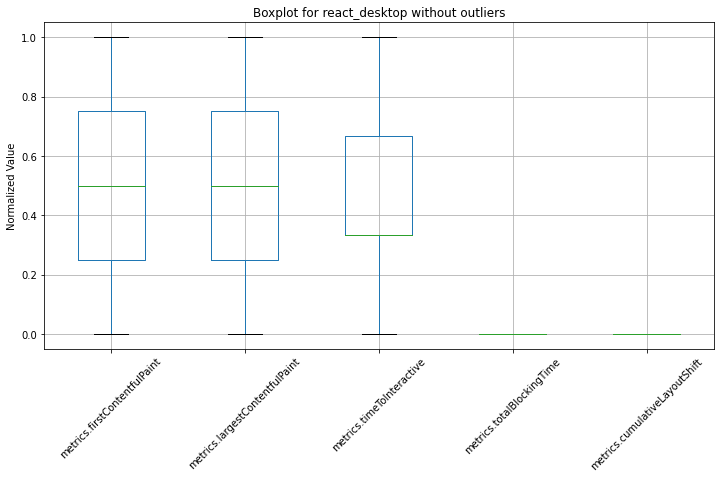

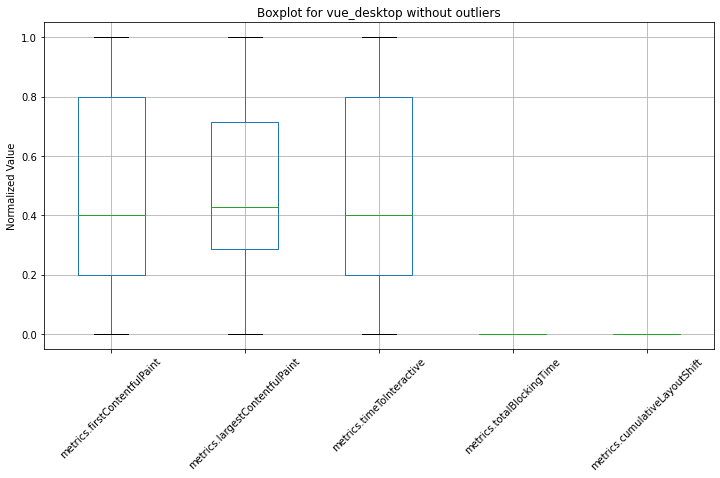

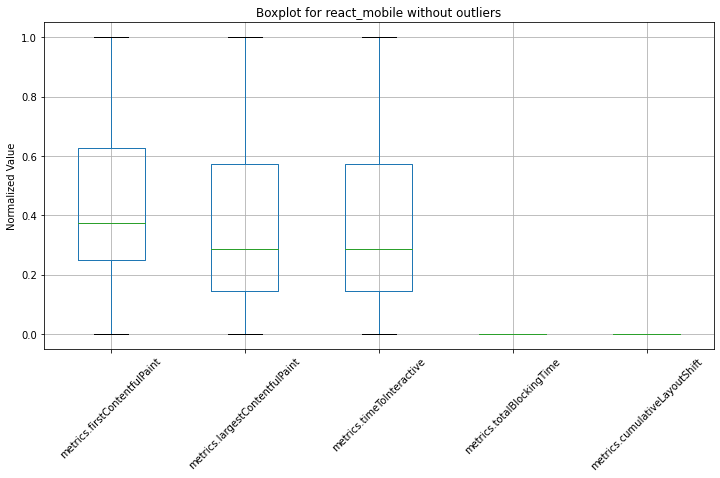

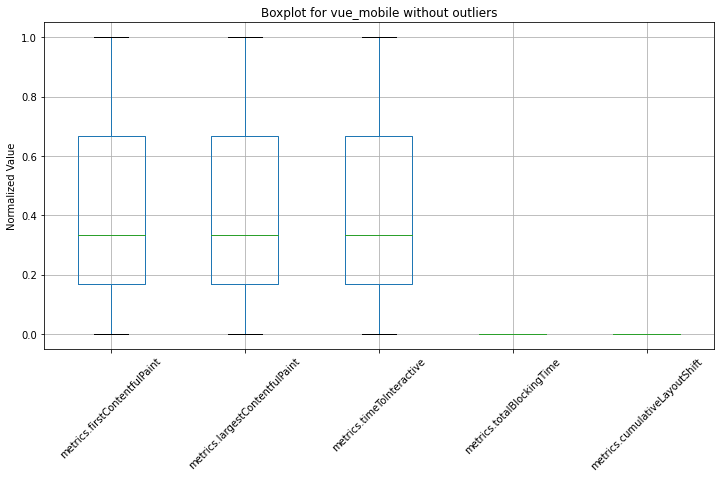

In [72]:
# Boxplot for the normalized dataframes without outliers
for name, df in dataframes_no_outliers_normalized.items():
    plt.figure(figsize=(12, 6))
    df.boxplot(column=[col for col in df.columns if "metrics" in col])
    plt.title(f"Boxplot for {name} without outliers")
    plt.ylabel("Normalized Value")
    plt.xticks(rotation=45)
    plt.show()

In [76]:
dataframes_no_outliers["vue_desktop"].head()

,performance,metrics.firstContentfulPaint,metrics.largestContentfulPaint,metrics.timeToInteractive,metrics.totalBlockingTime,metrics.cumulativeLayoutShift
0,0.98,800.0,1100.0,800.0,0.0,0.0
1,1.00,500.0,800.0,500.0,0.0,0.0
2,0.99,600.0,800.0,600.0,0.0,0.0
3,0.98,800.0,1000.0,800.0,0.0,0.0
5,1.00,400.0,500.0,400.0,0.0,0.0


In [ ]:

# Statistics
def get_statistics(df):
    stats = df.describe().loc[["mean", "50%", "std"]].rename(index={"50%": "median"})
    return stats

statistics = {name: get_statistics(df) for name, df in dataframes_no_outliers.items()}


In [83]:
statistics["react_desktop"]

,performance,metrics.firstContentfulPaint,metrics.largestContentfulPaint,metrics.timeToInteractive,metrics.totalBlockingTime,metrics.cumulativeLayoutShift
mean,0.978889,722.222222,1007.407407,751.851852,0.0,0.0
median,0.980000,700.000000,1000.000000,700.000000,0.0,0.0
std,0.009740,115.470054,138.469452,105.138628,0.0,0.0


In [80]:
for dataset_name, stats_df in statistics.items():
    print(f"\nStatistics for {dataset_name}:\n")
    print(stats_df)


Statistics for react_desktop:

        performance  metrics.firstContentfulPaint  \
mean       0.978889                    722.222222   
median     0.980000                    700.000000   
std        0.009740                    115.470054   

        metrics.largestContentfulPaint  metrics.timeToInteractive  \
mean                       1007.407407                 751.851852   
median                     1000.000000                 700.000000   
std                         138.469452                 105.138628   

        metrics.totalBlockingTime  metrics.cumulativeLayoutShift  
mean                          0.0                            0.0  
median                        0.0                            0.0  
std                           0.0                            0.0  

Statistics for vue_desktop:

        performance  metrics.firstContentfulPaint  \
mean       0.989310                    631.034483   
median     0.990000                    600.000000   
std        0.009232  

In [ ]:
output_file = "statistics_output.xlsx"

with pd.ExcelWriter(output_file) as writer:
    for dataset_name, stats_df in statistics.items():
        stats_df.to_excel(writer, sheet_name=dataset_name)

print(f"Statistics saved to {output_file}")

Statistics saved to statistics_output.xlsx


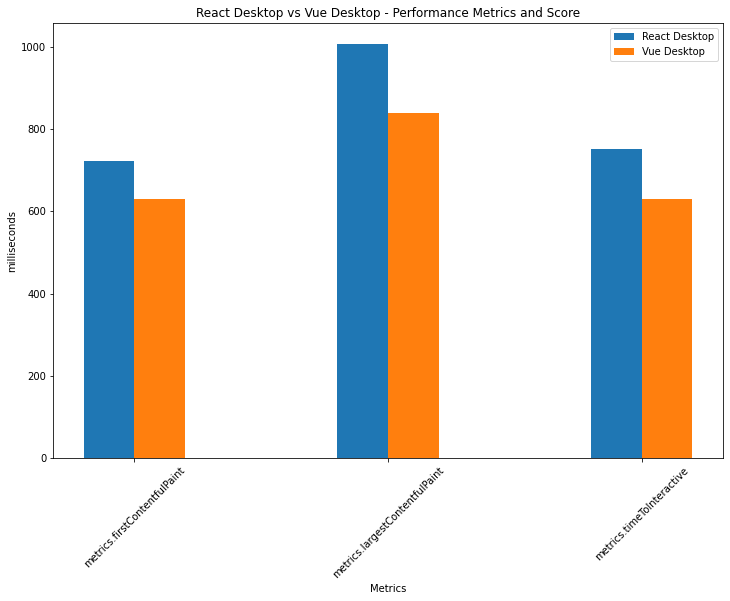

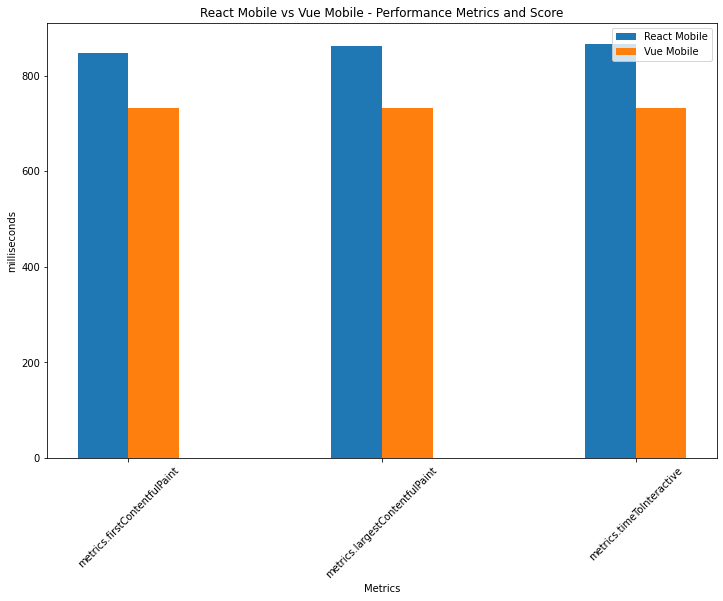

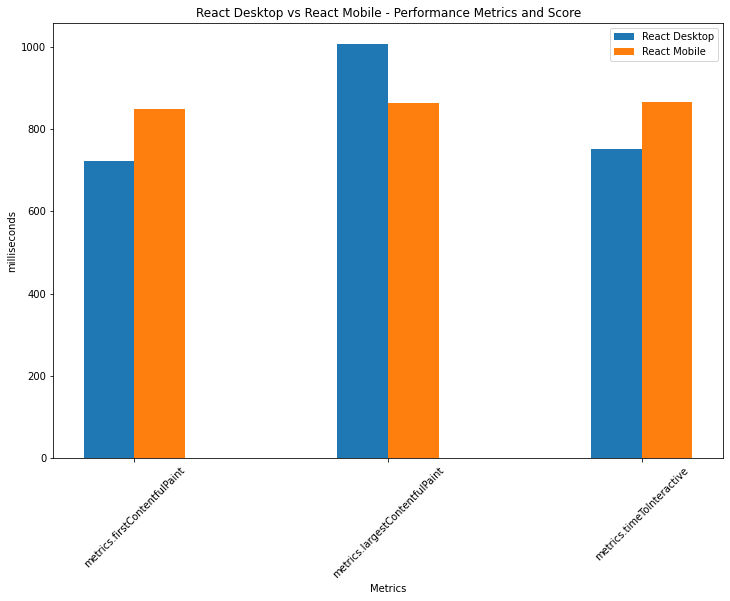

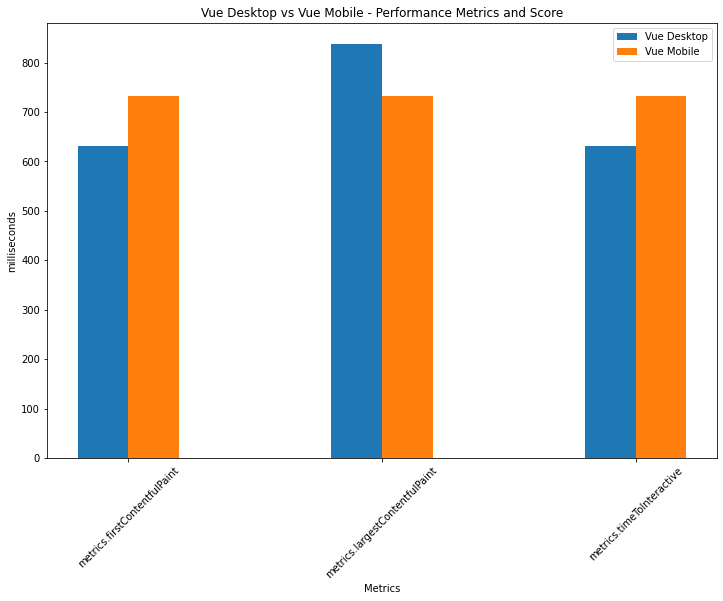

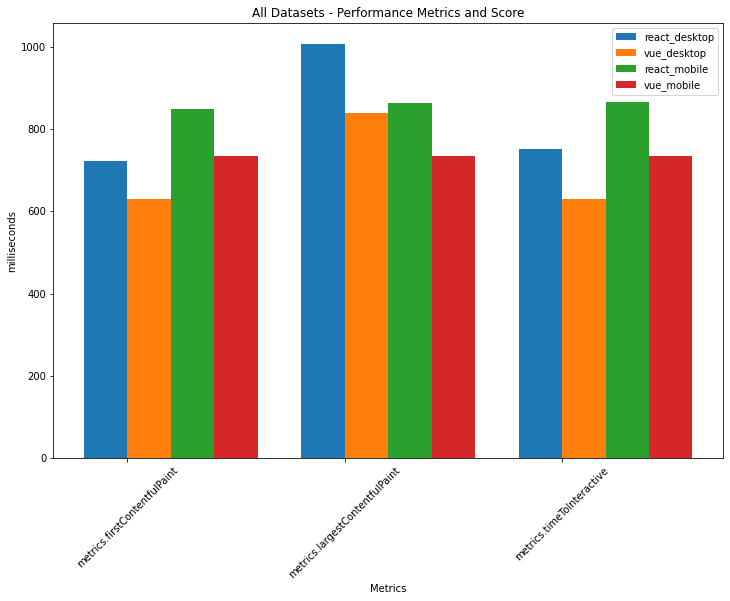

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_grouped_bar(metrics, datasets, title):
    labels = list(datasets.keys())
    num_metrics = len(metrics)
    x = np.arange(len(metrics))
    width = 0.2

    fig, ax = plt.subplots(figsize=(12, 8))

    for i, (label, df) in enumerate(datasets.items()):
        means = [df.loc['mean', metric] for metric in metrics]
        ax.bar(x + i * width, means, width, label=label)

    ax.set_xlabel('Metrics')
    ax.set_ylabel('milliseconds')
    ax.set_title(title)
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(metrics, rotation=45)
    ax.legend()

    plt.show()

metrics_to_compare = [
    'metrics.firstContentfulPaint', 
    'metrics.largestContentfulPaint', 
    'metrics.timeToInteractive',
]

# React Desktop vs Vue Desktop
plot_grouped_bar(metrics_to_compare, {
    'React Desktop': statistics['react_desktop'],
    'Vue Desktop': statistics['vue_desktop']
}, 'React Desktop vs Vue Desktop - Performance Metrics and Score')

# React Mobile vs Vue Mobile
plot_grouped_bar(metrics_to_compare, {
    'React Mobile': statistics['react_mobile'],
    'Vue Mobile': statistics['vue_mobile']
}, 'React Mobile vs Vue Mobile - Performance Metrics and Score')

# React Desktop vs React Mobile
plot_grouped_bar(metrics_to_compare, {
    'React Desktop': statistics['react_desktop'],
    'React Mobile': statistics['react_mobile']
}, 'React Desktop vs React Mobile - Performance Metrics and Score')

# Vue Desktop vs Vue Mobile
plot_grouped_bar(metrics_to_compare, {
    'Vue Desktop': statistics['vue_desktop'],
    'Vue Mobile': statistics['vue_mobile']
}, 'Vue Desktop vs Vue Mobile - Performance Metrics and Score')

# All datasets
plot_grouped_bar(metrics_to_compare, statistics, 'All Datasets - Performance Metrics and Score')


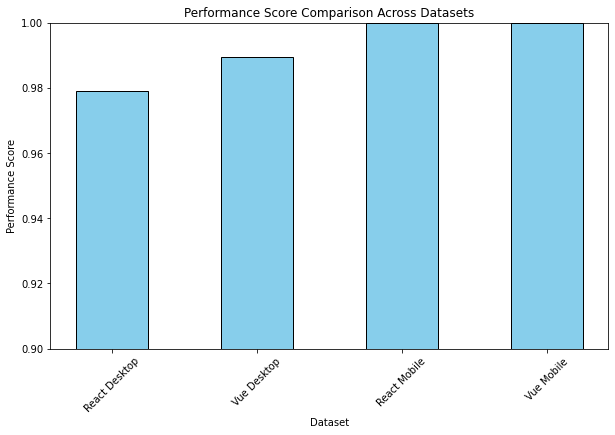

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_performance_comparison(datasets, title):
    labels = list(datasets.keys())
    performance_scores = [df.loc['mean', 'performance'] for df in datasets.values()]
    
    x = np.arange(len(labels)) 

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x, performance_scores, width=0.5, color='skyblue', edgecolor='black')

    ax.set_xlabel('Dataset')
    ax.set_ylabel('Performance Score')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)

    ax.set_ylim(0.9, 1)

    plt.show()


plot_performance_comparison({
    'React Desktop': statistics['react_desktop'],
    'Vue Desktop': statistics['vue_desktop'],
    'React Mobile': statistics['react_mobile'],
    'Vue Mobile': statistics['vue_mobile']
}, 'Performance Score Comparison Across Datasets')
